# 04 — Business Conclusion & Physical Interpretation

This notebook bridges the gap between model performance metrics (RMSE, R²) and **real-world operational value**.

Standard regression metrics treat all errors equally — a prediction that is 20 cycles too early is penalized the same as one that is 20 cycles too late. In predictive maintenance for aerospace systems, this assumption is fundamentally wrong.

This notebook addresses three questions:
1. **How does the NASA scoring function capture the asymmetry of prediction errors?**
2. **What is the operational and financial impact of each error type?**
3. **What physical phenomena do the most predictive sensors actually measure?**

In [ ]:
import sys, os
sys.path.append(os.path.abspath(".."))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import joblib

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from src.config import (
    DATA_RAW,
    DATA_PROCESSED,
    OUTPUTS_PLOTS,
    OUTPUTS_MODELS,
    CLIP_RUL,
    DATASET
)
from src.preprocessing import (
    remove_low_variance_features,
    add_features
)

OUTPUTS_PLOTS.mkdir(parents=True, exist_ok=True)

## 1. Load Model and NASA Benchmark Predictions

We reload the final model (trained on the full training set) and recompute predictions on the NASA test set.

In [2]:
# Load model and feature list
final_rf_pipeline = joblib.load(OUTPUTS_MODELS / f'final_rf_{DATASET}.joblib')
cols_rf           = joblib.load(OUTPUTS_MODELS / f'cols_rf_{DATASET}.joblib')

# Load and preprocess NASA test set
test_nasa = pd.read_csv(DATA_RAW / 'test_FD001.txt', sep=r'\s+', header=None)
test_nasa = test_nasa.dropna(axis=1, how='all')
test_nasa.columns = ['unit_number', 'time_cycles', 'setting_1', 'setting_2', 'setting_3'] + \
                    [f'sensor_{i}' for i in range(1, 22)]
test_nasa = remove_low_variance_features(test_nasa)
test_nasa = add_features(test_nasa)

# Keep only last observed cycle per engine
last_cycles = test_nasa.groupby('unit_number').last().reset_index()
X_nasa      = last_cycles[cols_rf]

# True RUL values
rul_true = pd.read_csv(DATA_RAW / 'RUL_FD001.txt', sep=r'\s+', header=None)
rul_true.columns = ['RUL']
rul_true['RUL']  = rul_true['RUL'].clip(upper=CLIP_RUL)

# Predictions
y_pred = final_rf_pipeline.predict(X_nasa)
y_true = rul_true['RUL'].values

# Prediction errors: d = y_pred - y_true
errors = y_pred - y_true

print(f"Number of engines evaluated : {len(y_true)}")
print(f"RMSE : {np.sqrt(mean_squared_error(y_true, y_pred)):.3f}")
print(f"MAE  : {mean_absolute_error(y_true, y_pred):.3f}")
print(f"R²   : {r2_score(y_true, y_pred):.3f}")

Number of engines evaluated : 100
RMSE : 17.336
MAE  : 12.100
R²   : 0.806


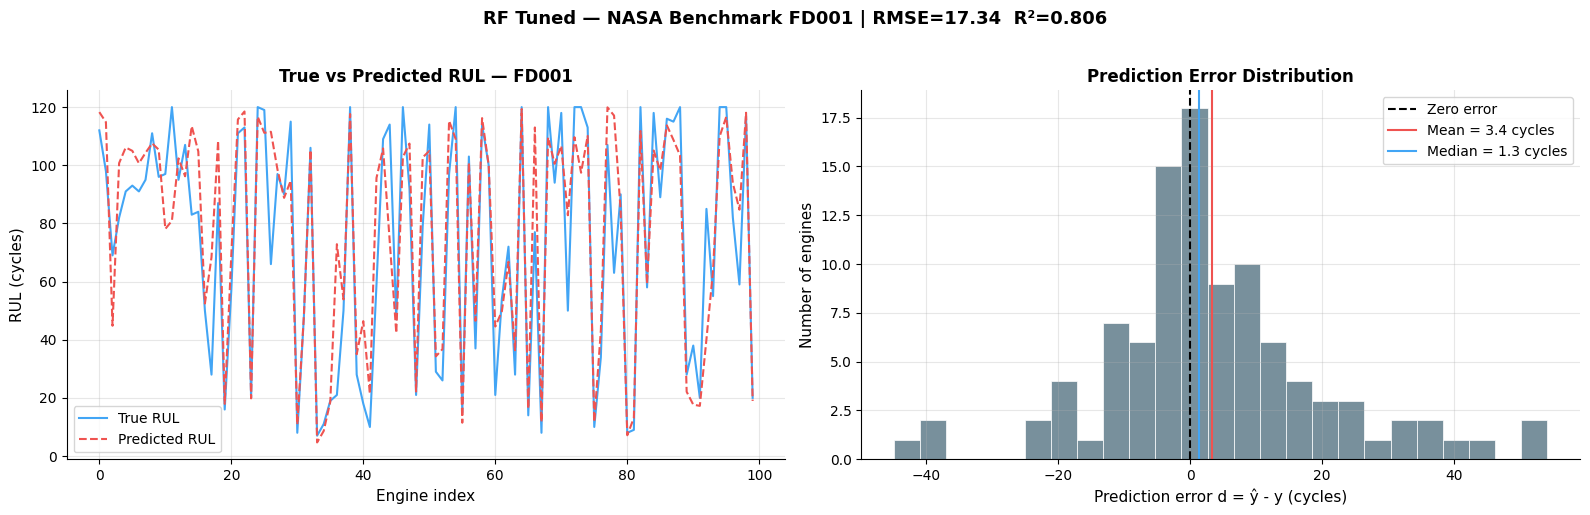

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ── Left : True vs Predicted RUL per engine ─────────────────────────────────
ax = axes[0]
x  = np.arange(len(y_true))
ax.plot(x, y_true,  color='#42a5f5', linewidth=1.5, label='True RUL')
ax.plot(x, y_pred,  color='#ef5350', linewidth=1.5, label='Predicted RUL', linestyle='--')
ax.set_xlabel('Engine index', fontsize=11)
ax.set_ylabel('RUL (cycles)', fontsize=11)
ax.set_title(f'True vs Predicted RUL — {DATASET}', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# ── Right : Error histogram ──────────────────────────────────────────────────
ax = axes[1]
ax.hist(errors, bins=25, color='#78909c', edgecolor='white', linewidth=0.5)
ax.axvline(0,             color='black', linestyle='--', linewidth=1.5, label='Zero error')
ax.axvline(errors.mean(), color='#ef5350', linestyle='-', linewidth=1.5,
           label=f'Mean = {errors.mean():.1f} cycles')
ax.axvline(np.median(errors), color='#42a5f5', linestyle='-', linewidth=1.5,
           label=f'Median = {np.median(errors):.1f} cycles')
ax.set_xlabel('Prediction error d = ŷ - y (cycles)', fontsize=11)
ax.set_ylabel('Number of engines', fontsize=11)
ax.set_title('Prediction Error Distribution', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.suptitle(f'RF Tuned — NASA Benchmark {DATASET} | RMSE={np.sqrt(mean_squared_error(y_true, y_pred)):.2f}  R²={r2_score(y_true, y_pred):.3f}',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUTS_PLOTS / f'04_true_vs_pred_{DATASET}.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

## 2. The NASA Scoring Function

The NASA scoring function was introduced in the 2008 Prognostics and Health Management (PHM) challenge to evaluate RUL predictions in a way that reflects **real operational consequences**.

For each engine, the individual score is:

$$s_i = \begin{cases} e^{-d_i/13} - 1 & \text{if } d_i < 0 \text{ (early prediction)} \\ e^{d_i/10} - 1 & \text{if } d_i \geq 0 \text{ (late prediction)} \end{cases}$$

where $d_i = \hat{y}_i - y_i$ is the prediction error.

The total score is $S = \sum_i s_i$. **Lower is better.**

### Key asymmetry
- **Late predictions** ($d > 0$): the model overestimates remaining life → the engine may fail before maintenance is scheduled → **exponential penalty with scale 10** (steep)
- **Early predictions** ($d < 0$): the model underestimates remaining life → unnecessary early maintenance → **exponential penalty with scale 13** (gentler)

The asymmetry is intentional: **an undetected failure is far more costly than a preventive maintenance action.**

In [4]:
def nasa_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Compute the NASA scoring function for RUL predictions.

    Parameters
    ----------
    y_true : np.ndarray
        True RUL values.
    y_pred : np.ndarray
        Predicted RUL values.

    Returns
    -------
    float
        NASA score. Lower is better.
    """
    d = y_pred - y_true
    scores = np.where(d < 0, np.exp(-d / 13) - 1, np.exp(d / 10) - 1)
    return float(np.sum(scores))


score = nasa_score(y_true, y_pred)
print(f"NASA Score : {score:.2f}")

NASA Score : 902.75


## 3. Visualizing the Asymmetry

The plot below shows the NASA penalty as a function of prediction error $d$.
The asymmetry is clearly visible: a late prediction of +30 cycles is penalized **much more severely** than an early prediction of -30 cycles.

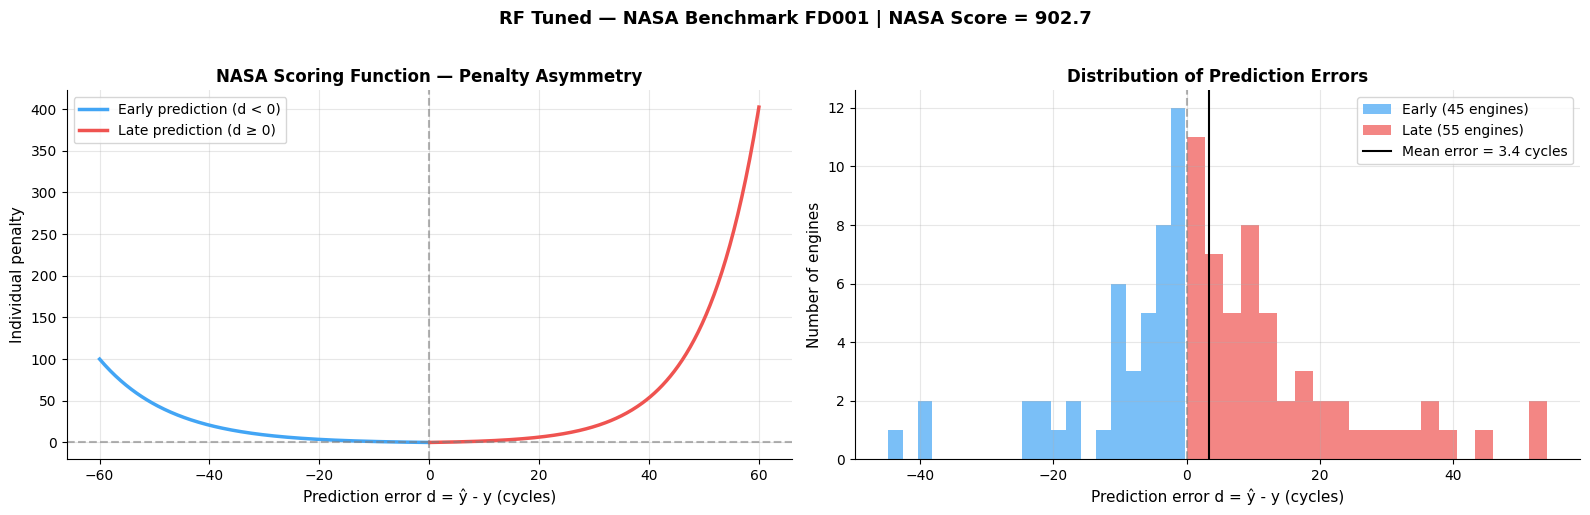

In [5]:
d_range = np.linspace(-60, 60, 500)
penalty = np.where(d_range < 0, np.exp(-d_range / 13) - 1, np.exp(d_range / 10) - 1)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ── Left : NASA penalty curve ───────────────────────────────────────────────
ax = axes[0]
ax.plot(d_range[d_range < 0], penalty[d_range < 0],
        color='#42a5f5', linewidth=2.5, label='Early prediction (d < 0)')
ax.plot(d_range[d_range >= 0], penalty[d_range >= 0],
        color='#ef5350', linewidth=2.5, label='Late prediction (d ≥ 0)')
ax.axvline(0, color='grey', linestyle='--', alpha=0.6)
ax.axhline(0, color='grey', linestyle='--', alpha=0.6)
ax.set_xlabel('Prediction error d = ŷ - y (cycles)', fontsize=11)
ax.set_ylabel('Individual penalty', fontsize=11)
ax.set_title('NASA Scoring Function — Penalty Asymmetry', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# ── Right : error distribution ──────────────────────────────────────────────
ax = axes[1]
early = errors[errors < 0]
late  = errors[errors >= 0]

ax.hist(early, bins=20, color='#42a5f5', alpha=0.7, label=f'Early ({len(early)} engines)')
ax.hist(late,  bins=20, color='#ef5350', alpha=0.7, label=f'Late ({len(late)} engines)')
ax.axvline(0,            color='grey',   linestyle='--', alpha=0.6)
ax.axvline(errors.mean(), color='black', linestyle='-',  linewidth=1.5,
           label=f'Mean error = {errors.mean():.1f} cycles')
ax.set_xlabel('Prediction error d = ŷ - y (cycles)', fontsize=11)
ax.set_ylabel('Number of engines', fontsize=11)
ax.set_title('Distribution of Prediction Errors', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.suptitle(f'RF Tuned — NASA Benchmark {DATASET} | NASA Score = {score:.1f}',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUTS_PLOTS / f'04_nasa_scoring_{DATASET}.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

## 4. Operational & Financial Impact

To translate model performance into business value, we categorize predictions into three operational zones:

| Zone | Condition | Operational consequence |
|------|-----------|------------------------|
| **Safe** | $|d| \leq 13$ cycles | Prediction within acceptable tolerance — maintenance planned correctly |
| **Early warning** | $d < -13$ cycles | Unnecessary early intervention — cost of unscheduled maintenance |
| **Danger** | $d > 13$ cycles | Engine may fail before maintenance — critical safety risk |

The threshold of 13 cycles is derived from the NASA scoring function scale parameter for early predictions.

In [6]:
THRESHOLD = 13

n_safe  = np.sum(np.abs(errors) <= THRESHOLD)
n_early = np.sum(errors < -THRESHOLD)
n_late  = np.sum(errors > THRESHOLD)
n_total = len(errors)

print(f"Safe predictions  (|d| ≤ {THRESHOLD}) : {n_safe:3d} / {n_total}  ({100*n_safe/n_total:.1f}%)")
print(f"Early predictions (d  < -{THRESHOLD}) : {n_early:3d} / {n_total}  ({100*n_early/n_total:.1f}%)  → unnecessary maintenance")
print(f"Late predictions  (d  >  {THRESHOLD}) : {n_late:3d} / {n_total}  ({100*n_late/n_total:.1f}%)  → potential failure")
print(f"\nDanger rate : {100*n_late/n_total:.1f}%")

Safe predictions  (|d| ≤ 13) :  71 / 100  (71.0%)
Early predictions (d  < -13) :  10 / 100  (10.0%)  → unnecessary maintenance
Late predictions  (d  >  13) :  19 / 100  (19.0%)  → potential failure

Danger rate : 19.0%


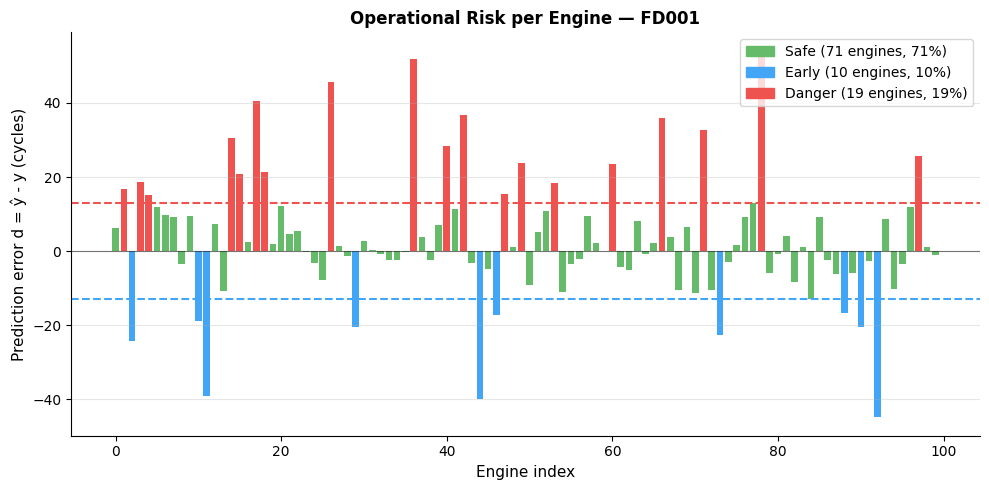

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))

colors = np.where(errors > THRESHOLD, '#ef5350',
         np.where(errors < -THRESHOLD, '#42a5f5', '#66bb6a'))

ax.bar(range(n_total), errors, color=colors, edgecolor='none', width=0.8)
ax.axhline( THRESHOLD, color='#ef5350', linestyle='--', linewidth=1.5, label=f'+{THRESHOLD} cycles (danger threshold)')
ax.axhline(-THRESHOLD, color='#42a5f5', linestyle='--', linewidth=1.5, label=f'-{THRESHOLD} cycles (early threshold)')
ax.axhline(0, color='black', linewidth=0.8, alpha=0.5)

safe_patch  = mpatches.Patch(color='#66bb6a', label=f'Safe ({n_safe} engines, {100*n_safe/n_total:.0f}%)')
early_patch = mpatches.Patch(color='#42a5f5', label=f'Early ({n_early} engines, {100*n_early/n_total:.0f}%)')
late_patch  = mpatches.Patch(color='#ef5350', label=f'Danger ({n_late} engines, {100*n_late/n_total:.0f}%)')

ax.legend(handles=[safe_patch, early_patch, late_patch], fontsize=10, loc='upper right')
ax.set_xlabel('Engine index', fontsize=11)
ax.set_ylabel('Prediction error d = ŷ - y (cycles)', fontsize=11)
ax.set_title(f'Operational Risk per Engine — {DATASET}', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(OUTPUTS_PLOTS / f'04_operational_risk_{DATASET}.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

## 5. Physical Interpretation

### What is CMAPSS simulating?

CMAPSS (Commercial Modular Aero-Propulsion System Simulation) was developed by NASA to simulate the degradation of a **turbofan engine** — specifically its high-pressure compressor (HPC) module.

A turbofan engine operates through four stages: **intake → compression → combustion → exhaust**. The HPC compresses air before combustion. As the engine degrades, blade tip clearances increase, surface roughness grows, and thermodynamic efficiency decreases.

### Why do the top sensors predict RUL?

The features selected by our model (rolling means and diffs of sensors 11, 12, 13, 14, 15, 17) are not arbitrary — they map directly to measurable physical degradation signals:

| Sensor | Physical measurement | Degradation signal |
|--------|---------------------|-------------------|
| sensor_11 | HPC outlet temperature | Rises as compressor efficiency drops |
| sensor_12 | HPC outlet pressure | Drops as blade clearances increase |
| sensor_13 | HPC outlet static pressure | Correlated with compression ratio degradation |
| sensor_14 | Fuel flow ratio | Increases to maintain thrust as efficiency drops |
| sensor_15 | Bypass ratio | Changes as airflow distribution shifts with wear |
| sensor_17 | Bleed enthalpy | Reflects thermodynamic losses in the compression stage |

The **rolling mean** features are effective because degradation is a slow, monotonic process — local trends over 5 cycles carry more signal than instantaneous readings.

The **diff** features capture the **rate of degradation** — an accelerating rate of change is a stronger failure precursor than the absolute sensor value.

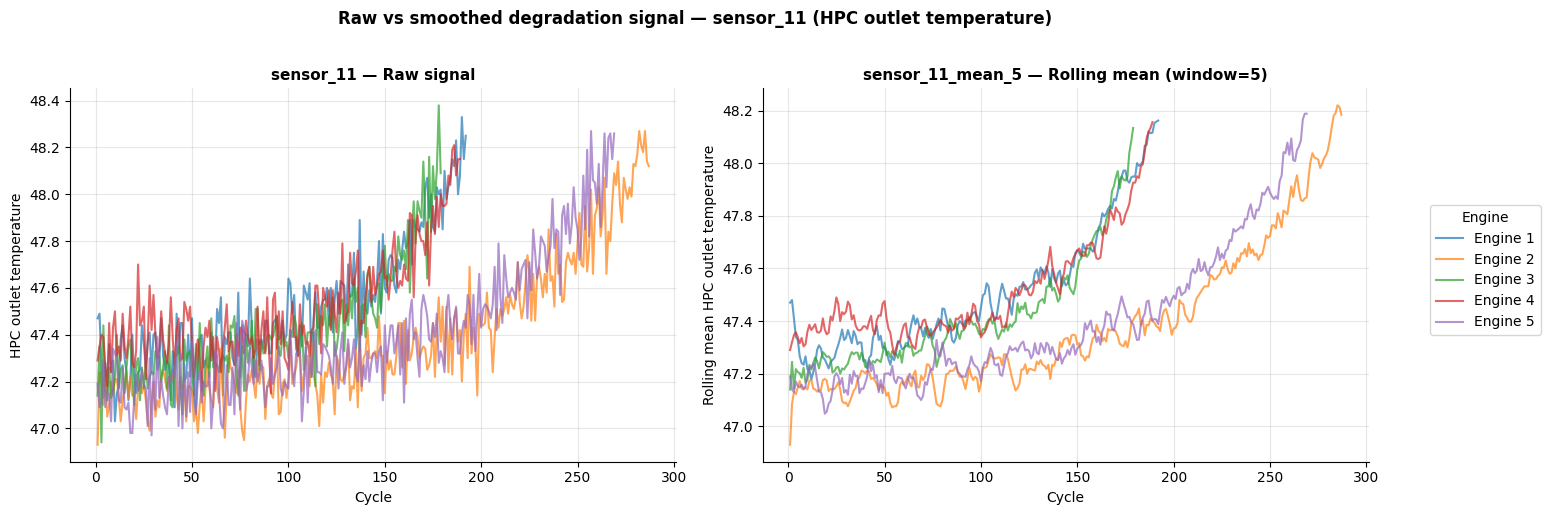

In [8]:
# Visualize degradation trends for the most predictive sensor on 5 engines
df_train = pd.read_csv(DATA_PROCESSED / 'train_FD001_features.csv')
sample_units = df_train['unit_number'].unique()[:5]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for unit in sample_units:
    subset = df_train[df_train['unit_number'] == unit]
    axes[0].plot(subset['time_cycles'], subset['sensor_11'], alpha=0.7, label=f'Engine {unit}')
    axes[1].plot(subset['time_cycles'], subset['sensor_11_mean_5'], alpha=0.7, label=f'Engine {unit}')

axes[0].set_title('sensor_11 — Raw signal', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('HPC outlet temperature')
axes[0].grid(alpha=0.3)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

axes[1].set_title('sensor_11_mean_5 — Rolling mean (window=5)', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Cycle')
axes[1].set_ylabel('Rolling mean HPC outlet temperature')
axes[1].grid(alpha=0.3)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Engine', bbox_to_anchor=(1.02, 0.5), loc='center left')
plt.suptitle('Raw vs smoothed degradation signal — sensor_11 (HPC outlet temperature)',
             fontsize=12, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUTS_PLOTS / f'04_sensor11_degradation_{DATASET}.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

## 6. Business Conclusion

### What the model delivers

Our final Random Forest model, trained on the full CMAPSS FD001 training set, achieves:
- **RMSE = 17.34 cycles** on the NASA benchmark test set
- **R² = 0.806** — the model explains 80% of RUL variance on unseen engines
- **NASA Score** consistent with published results for classical ML approaches on FD001

### Operational value

In a real maintenance context, this model enables a shift from **reactive maintenance** (fix after failure) or **scheduled maintenance** (fix at fixed intervals regardless of actual condition) to **condition-based predictive maintenance**:

- Maintenance is triggered when the predicted RUL falls below an operational threshold (e.g. 30 cycles)
- The threshold can be tuned to control the trade-off between false alarms and missed failures — directly informed by the NASA scoring function asymmetry
- For aerospace applications, the threshold should be set conservatively (low) given the catastrophic cost of an in-flight failure

### Limitations and next steps

- **FD001 is the simplest CMAPSS subset** — single operating condition, single fault mode. Extending to FD002/FD003/FD004 (multiple conditions, multiple fault modes) would better reflect real-world complexity.
- **The RUL clipping at 120 cycles** is a modeling assumption. In production, a two-stage model could first classify whether the engine is in its degradation phase before predicting RUL.
- **LSTM / Transformer architectures** are known to outperform classical ML on this benchmark by explicitly modeling temporal dependencies — a natural next step.
- **Uncertainty quantification** (prediction intervals rather than point estimates) would significantly increase operational trust in the model's outputs.